<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>

Привет Диана! Меня зовут Марат, и я буду твоим ревьюером. Спешу сообщить что все ключевые этапы в работе выполнены,  с задачей тебе удалось справиться. По поводу обращения - в IT сфере принято общаться на «ты» :) Но, если привычней на «вы», дай знать. Как ревьюера моя задача помочь тебе в развитии, дав хорошие советы. Я внимательно посмотрю твой код, ознакомлюсь с твоими выводами и оставлю комментарии. Где то могу предложить небольшие исправление в коде, но ненавязчиво. Где потребуются уточнения, я оставлю много наводящих вопросов. Они помогут тебя с поиском верного решения.

Все мои комментарии размечены по цветам, для лучшего восприятия. 
    
<div class="alert alert-success">Зеленым цветом и словом «Успех» отмечены особо удачные и элегантные решения, которыми ты можешь гордиться. </div>
        
<div class="alert alert-warning">Желтым и значком словом «Совет», помечены решения у которых есть альтернативные решения, более оптимальные. Ты можешь найти их сразу и доработать проект, или отложить это на потом, для будущих проектах. Проект будет принят и без их доработки. </div>
        
<div class="alert alert-danger"> Красным цветом и значком словом «Ошибка» помечу твои решения, на которые стоит обратить внимание прежде всего. После их доработки проект будет принят. </div>
        
Залог успеха - работа сообща, взаимное уважение и работа в диалоге. Поэтому, помечай свои ответные комментарии на мои реплики заметным цветом или курсивом, так мне будет легче их отслеживать. Пожалуйста, не изменяй и не удаляй мои комментарии. Все это поможет выполнить повторную проверку быстрей.

</div>

# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»).

**Цель исследования** — построить модель для задачи классификации, которая выберет подходящий тариф.

**Ход исследования**

О качестве данных известно, что, как минимум, не требуется предобработка, однако, все равно проверим повторно. 

Таким образом, исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Анализ.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Вступление в работу очень важно, так человек, который смотрит твой проект (и на работе в том числе) будет сразу введен в курс дела.





</div>

## Изучение данных

In [1]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn import tree
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import GridSearchCV


from collections import Counter
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import TomekLinks

In [3]:
df = pd.read_csv('/datasets/users_behavior.csv')

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет: 

Все-таки стоит импорт библиотек и выгрузку данных разнести в разные ячейки, так стилистически более правильно.

</div>


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Собираем все импорты в верхней части, чтобы легче было ориентироваться и добавлять новые по необходимости. 


<div class="alert alert-warning">

Совет:     
    


- кстати есть рекомендации PEP-8 при написании кода, в том числе и для импортов. Если интересно можешь почитать [тут](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html) 


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Исправила этот момент
    </font>
</div>

Откроем файл и изучим документацию:

In [4]:
df.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Предобработка данных 

Убедимся в отсутствии пропусков и дубликатов:

In [48]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [6]:
df.duplicated().sum() == 0

True

Оценим аномальность параметров:

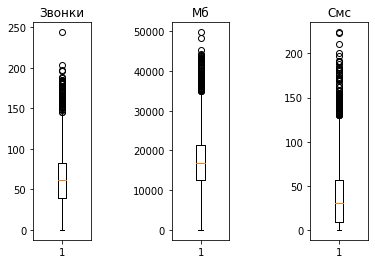

In [7]:
fig = plt.figure()

ax_1 = fig.add_subplot(1, 5, 1)
ax_2 = fig.add_subplot(1, 5, 3)
ax_3 = fig.add_subplot(1, 5, 5)

ax_1.boxplot(df['calls']);
ax_1.set_title('Звонки');
ax_2.boxplot(df['mb_used']);
ax_2.set_title('Мб');
ax_3.boxplot(df['messages']);
ax_3.set_title('Смс');

Все "выбросы" более-менее близки к реальности, поэтому ограничивать параметры мы не будем.

Проверим данные на сбалансированность классов (ибо мы решаем задачу классификации):

In [8]:
assert df[df['is_ultra'] == 1].shape[0] / df[df['is_ultra'] == 0].shape[0] != 1, 'Данные сбалансированны по классам'
print('Данные несбалансированны по классам')

Данные несбалансированны по классам


Предполагаемые причины дисбаланса:
* Наличие дубликатов
* Естественные причины (целевая переменная - генотипы и тп.)
* Недостатка размеченных данных

В нашем случая мы имеем стандартную задачу классификации, соответственно, рассмотрим следующую меру по перебалансировки - поиск связи Томека. Он состоит в поиске элементов противоположного класса на близком расстоянии. Это обеспечивает более точную классификацию.

In [9]:
X, y = df.drop(['is_ultra'], axis=1), df['is_ultra'] 
print('Original dataset shape %s' % Counter(y))
ad = TomekLinks(sampling_strategy='majority')
X_res, y_res = ad.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 2229, 1: 985})
Resampled dataset shape Counter({0: 1966, 1: 985})


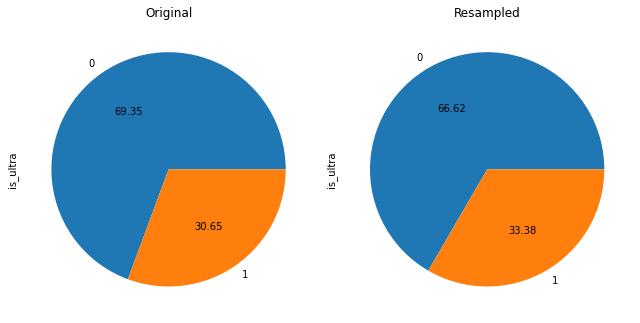

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(9, 5))
autopct = "%.2f"
y.value_counts().plot.pie(autopct=autopct, ax=axs[0])
axs[0].set_title("Original")
y_res.value_counts().plot.pie(autopct=autopct, ax=axs[1])
axs[1].set_title("Resampled")
fig.tight_layout()

Теперь когда данные более сбалансированны и предобработаны можем перейти к обучению моделей. 

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

👍 Данные изучены. Небольшой EDA не помешает, так как это аналитический проект. В данном проекте датасет "чистенький", но кто знает какой датасет нас будет ждать завтра, надо быть готовым )

    

<div class="alert alert-warning">



Совет: 

Стоило еще проверить датасет на сбалансированность классов в таргете это важная информация при моделировании и помогло решить бонусное задание сразу.  Тут можно [почитать](https://dyakonov.org/2021/05/27/imbalance/) зачем мы обращаем внимание на это



</div>


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Добавила предобработку и проверку на сбалансированность + adasyn как метод пересбалансировки.</font>
</div>

## Разделение на выборки

Прежде чем переходить к исследованию, необходимо разделить выборку на валидационную и тренировочную. Однако, перед этим определим признаки и целевую переменную:

`target` - за нее возьмем столбец `ultra` (ибо мы решаем задачи классификации, где подбираем наилучший тариф)

`features` - все кроме столбца `ultra`

In [11]:
features = X_res
target = y_res

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1.

In [12]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, 
    test_size=0.2, 
    random_state=42,
    stratify=target
)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=target_train
)

`features_train & target_train` - тренировочная выборка

`features_valid & target_valid` - валидационная выборка

`features_test & target_test` - тестовая выборка

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Все правильно!


<div class="alert alert-warning">



Совет: 


- Обрати внимание на аргумент stratify, он позволит сохранить изначальное распределение таргетов во всех новых датасетах.  Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым


- После разбиения лучше перестраховаться и использовать .shape, для контроля за корректностью разбиения



<div>



## Исследование моделей 

### Решающие дерево 

#### Accuracy

Сначала оценим долю правильных ответов на валидационной:

In [13]:
#через GridSearchCV() найдем лучшие гиперпараметры для модели
parametrs = {'max_depth': range(1, 10),
             'min_samples_leaf': range(1,8),
             'min_samples_split': range(2,10,2)}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), parametrs, cv=5)
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}

In [14]:
model = DecisionTreeClassifier(random_state=42, 
                               max_depth = grid.best_params_['max_depth'],
                               min_samples_leaf = grid.best_params_['min_samples_leaf'],
                               min_samples_split = grid.best_params_['min_samples_split'])
model.fit(features_train, target_train) 
best_result_dt = model.score(features_valid, target_valid)
print("Accuracy наилучшей модели на валидационной выборке:", best_result_dt)

Accuracy наилучшей модели на валидационной выборке: 0.7923728813559322


Изобразим DecisionTreeClassifier() и посмотрим как выглядит модель с найденными гиперпараметрами:

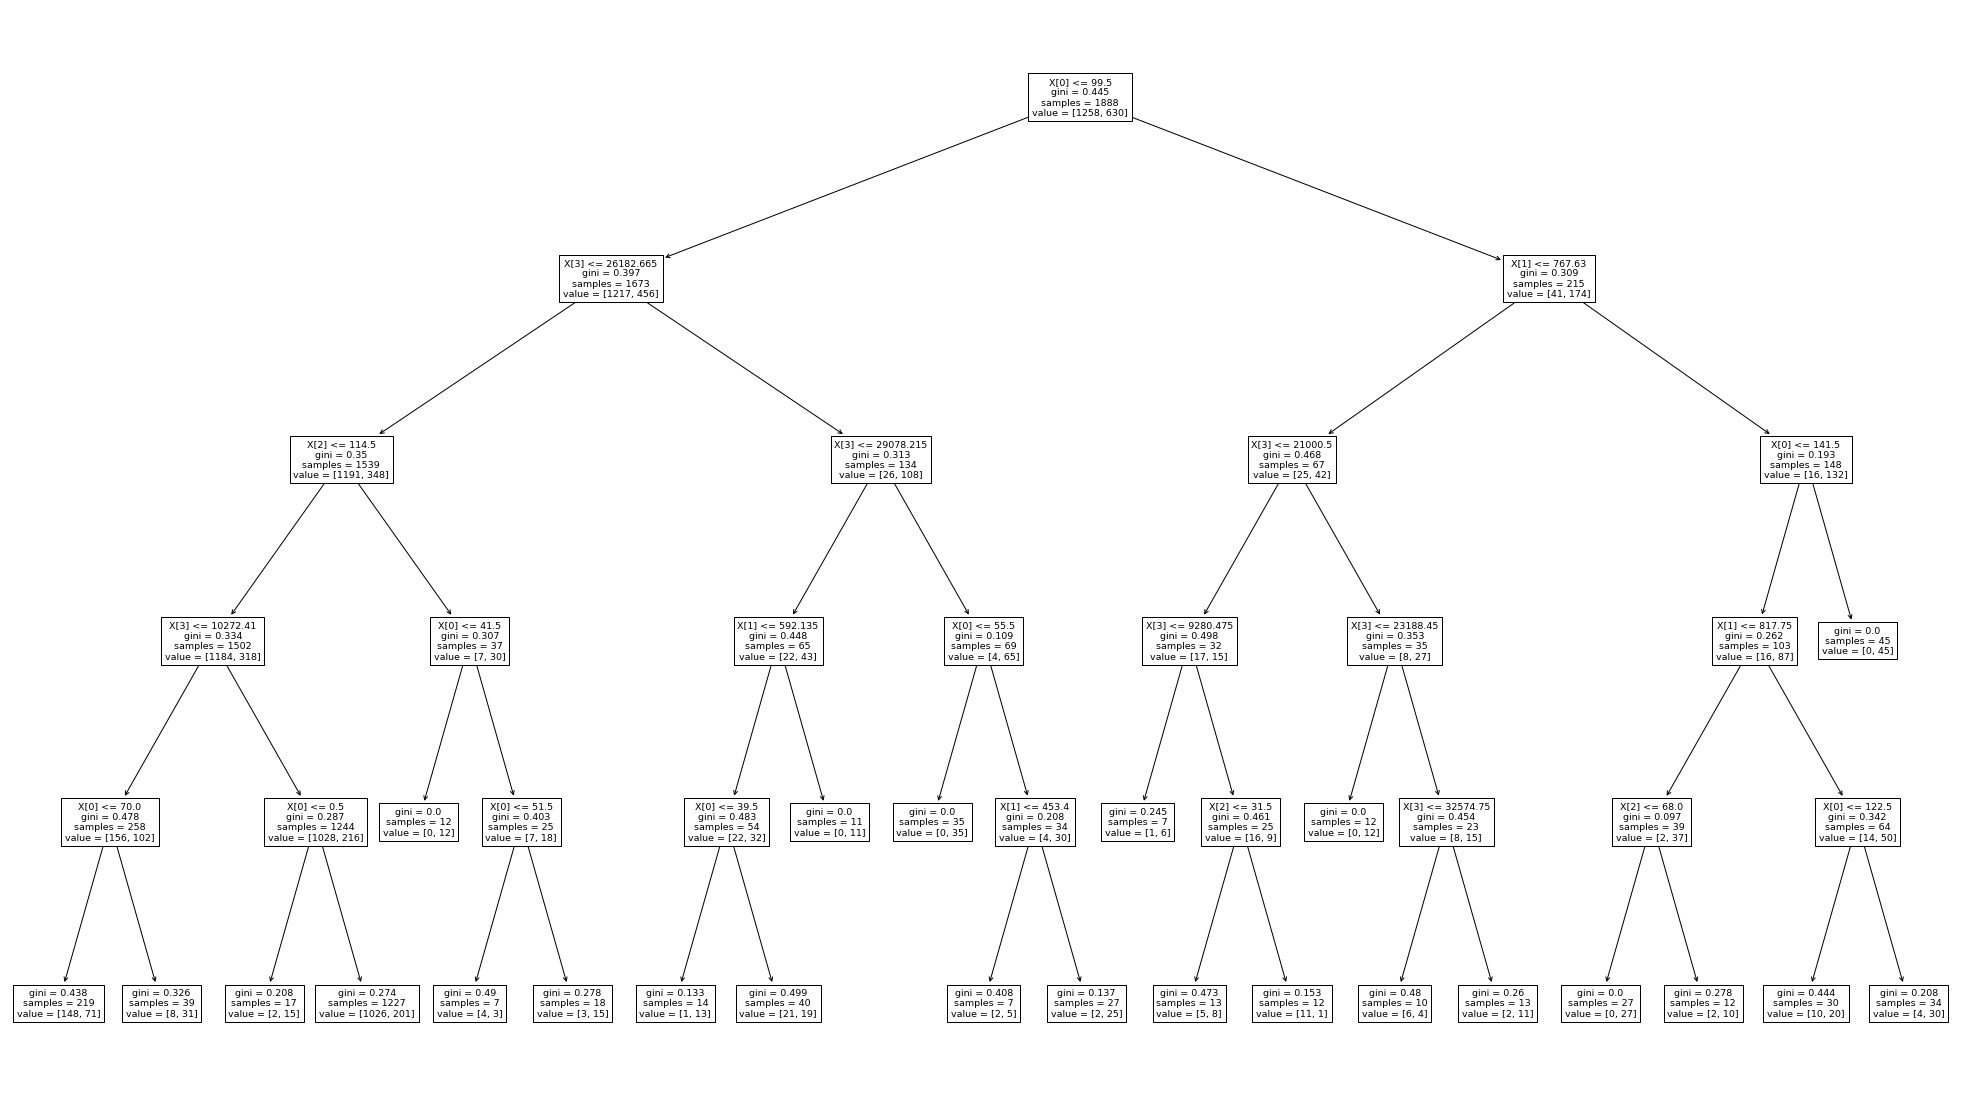

In [15]:
#через модуль tree и plot_tree изобразим DT
fig = plt.figure(figsize=(25,20))
clf = tree.DecisionTreeClassifier(random_state=42, 
                                  max_depth = grid.best_params_['max_depth'],
                                  min_samples_leaf = grid.best_params_['min_samples_leaf'],
                                  min_samples_split = grid.best_params_['min_samples_split'])
clf = clf.fit(features_train, target_train)
_ = tree.plot_tree(clf)

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:
 
Работа выполнена в соответствии с критериями: 
 - модель обучена на обучающем наборе
 - получена оценка качества на валидационном наборе
 - перебор гиперпараметров осуществляется в цикле


<div class="alert alert-warning">


Совет как сделать проект лучше: 


- Ты тут и ниже лучшую модель записываешь под тем же названием  - best_model_v, поэтому в следующем цикле она перезапишется Не лучше ли использовать    разные названия допустим best_model_dt и best_model_rf, иначе зачем они вообще нужны?     
    

- tree_plot можно построить, глянуть как DT сплиты делает 


- Можно добавить график, хорошо оформленный график украсит проект. Тут на графике можно посмотреть как при изменении гиперпараметров меняется точность на train и validation датасете, Такой способ используют чтобы лучше отследить переобучение



</div>



<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка:

    
На тестовой мы делаем проверку в самом конце    
    
</div>


**Наблюдение**: accurancy пвысокое на выборке, больше порога в 0,75. Получается лучшей из моделей типа TreeClassifier будет та, что имеет такие гиперпараметры:

`model = DecisionTreeClassifier(random_state=42, max_depth=5,min_samples_leaf = 7, min_samples_split = 2)`

#### Confusion matrix, recall, precision

Не будем останавливаться на одном показателе accurancy, проанализируем работу модели через другую метрику - `Confusion matrix`.

In [16]:
tn_v, fp_v, fn_v, tp_v = confusion_matrix(target_valid, model.predict(features_valid), labels = [0, 1]).ravel() 

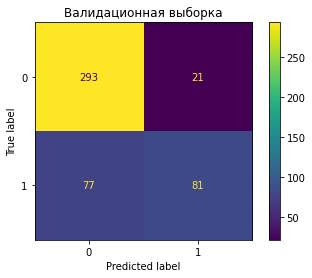

In [17]:
confusion_matrix_2 = confusion_matrix(target_valid, model.predict(features_valid))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])
cm_display.plot()
plt.title('Валидационная выборка')
plt.show()

Найдем значения других метрик, связанных с `Confusion matrix` - `recall`, `precision`:

In [18]:
r_v_dt = tp_v / (tp_v + fn_v)
p_v_dt = tp_v / (tp_v + fp_v)
print(f'Recall_valid = {r_v_dt}')
print(f'Precision_valid = {p_v_dt}')

Recall_valid = 0.5126582278481012
Precision_valid = 0.7941176470588235


**Наблюдение**: значение recall говорит о средней доли правильно найденных положительных объектов среди всех объектов положительного класса, целых 51%. precision же говорит о правильных предсказания, чья доля составляет около 80%!


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

👍 за доп метрики и ConfusionMatrixDisplay
</div>


### Случайный лес

#### Accuracy

Сначала оценим долю правильных ответов на валидационной:

In [19]:
#через GridSearchCV() найдем лучшие гиперпараметры для модели
parametrs = {'n_estimators': range(8,100,30),
             'min_samples_leaf': range(2,5),
             'max_depth': range(1, 10)}

grid = GridSearchCV(RandomForestClassifier(random_state=42), parametrs, cv=5)
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 98}

In [20]:
model = RandomForestClassifier(random_state=42, 
                               max_depth = grid.best_params_['max_depth'],
                               min_samples_leaf = grid.best_params_['min_samples_leaf'],
                               n_estimators = grid.best_params_['n_estimators'])
model.fit(features_train, target_train) 
best_result_rf = model.score(features_valid, target_valid)
print("Accuracy наилучшей модели на валидационной выборке:", best_result_rf)

Accuracy наилучшей модели на валидационной выборке: 0.8029661016949152




<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:
    
По большему числу гиперпараметров перебор -   тем лучше метрика. Здорово   




<div class="alert alert-warning">


Совет как использовать более продвинутые инструменты: 

- Здорово что использовал перебор не по одному гиперпараметру. Поэтому посоветую поизучать sklearn-ий GreedSearch. В случаи использования GridSearch, не нужно будет заранее делать валидационную выборку, лучшую метрику автоматом сохранят в best_score_, а лучшую модель (переобученная уже на полном наборе данных) будет хранить в best_estimator_. 
Если хочешь можешь сразу переделать. 

 
- Когда что то долго крутиться, можно использовать  %%time - ставишь на самый вверх ячейки с кодом, время выполнения которого хочешь замерить, может не знаешь.  Быстрее не станет, но все будут видеть стоит ли ждать не отходя от ПК или можно сходить чаек поставить ))  А еще есть tqdm, показывает на каком этапе у нас работа в цикле происходит


</div>


**Наблюдение**: accurancy примерно высокое на выборке, больше 0,75. Получается лучшей из моделей типа RandomForestClassifier будет та, что имеет такие гиперпараметры:

`model = DecisionTreeClassifier(random_state=42, n_estimators=98, min_samples_leaf=3, max_depth=9)`

Более того, accuracy на тестовой выборке показал себя лучше, чем в предыдущей модели. 

#### Confusion matrix, recall, precision

Не будем останавливаться на одном показателе accurancy, проанализируем работу модели через другую метрику - `Confusion matrix`.

In [21]:
tn_v, fp_v, fn_v, tp_v = confusion_matrix(target_valid, model.predict(features_valid), labels = [0, 1]).ravel() 

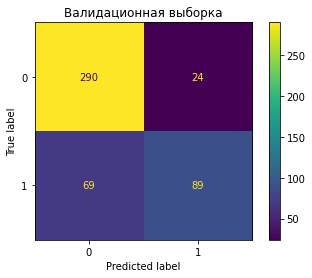

In [22]:
confusion_matrix_2 = confusion_matrix(target_valid, model.predict(features_valid))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])
cm_display.plot()
plt.title('Валидационная выборка')
plt.show()

Найдем значения других метрик, связанных с `Confusion matrix` - `recall`, `precision`:

In [23]:
r_v_rf = tp_v / (tp_v + fn_v)
p_v_rf = tp_v / (tp_v + fp_v)
print(f'Recall_valid = {r_v_rf}')
print(f'Precision_valid = {p_v_rf}')

Recall_valid = 0.5632911392405063
Precision_valid = 0.7876106194690266


**Наблюдение**: значение recall о средней доли правильно найденных положительных объектов среди всех объектов положительного класса, целых 56%. precision же говорит о правильных предсказания, чья доля составляет около 78%.

Стоит отметить, что у предыдущей модели доля правильных предсказаний была ниже.

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка:

    
Опять же, на  test датасете пока никаких метрик  не считаем   
</div>


### Логическая регрессия

#### Accuracy


In [24]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
p_v = model.predict(features_valid)
a_v = model.score(features_valid, target_valid)
print("Accuracy на валидационной выборке:", a_v)

Accuracy на валидационной выборке: 0.6800847457627118


#### Confusion matrix, recall, precision

Не будем останавливаться на одном показателе accurancy, проанализируем работу модели через другую метрику - `Confusion matrix`.

In [25]:
tn_v, fp_v, fn_v, tp_v = confusion_matrix(target_valid, model.predict(features_valid), labels = [0, 1]).ravel() 

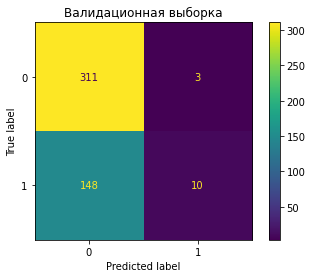

In [26]:
confusion_matrix_2 = confusion_matrix(target_valid, model.predict(features_valid))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])
cm_display.plot()
plt.title('Валидационная выборка')
plt.show()

Найдем значения других метрик, связанных с `Confusion matrix` - `recall`, `precision`:

In [27]:
r_v = tp_v / (tp_v + fn_v)
p_v = tp_v / (tp_v + fp_v)
print(f'Recall_valid = {r_v}')
print(f'Precision_valid = {p_v}')

Recall_valid = 0.06329113924050633
Precision_valid = 0.7692307692307693


**Наблюдение**: recall очень низок, что говорит о мало найденных правильных объектов. precision же высок, но только на валидационной выборке. 

## Проверка модели на тестовой выборке и доп. исследование на адекватность


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

К данному этапу мы должны подойти с одной выбранной моделью. Диана, о логике использования датасетов:
    
1. На train мы обучаем
2. По валидации смотрим на результаты обучения (следим чтобы не было переобучения и/или делаем подбор гиперпараметров).  И выбираем лучшую модель. 
3. Тестовая (out-of_sample) у нас для финальной проверки, когда определена модель с конкретными гиперпараметрами. Использование тестовой выборки, чтобы еще раз посмотреть на модели - это нарушение логической цепочки моделирования. 

А как сделала ты может сложиться впечатление что мы на тестовой по прежнему что то выбираем, но выбор делаем по валидационной, и если лучшая на валидации модель покажет на test результат хуже требуемого, мы начнем процесс моделирования сначала.
    
 [Вот](https://towardsdatascience.com/why-do-we-need-a-validation-set-in-addition-to-training-and-test-sets-5cf4a65550e0   ) тут можно дополнительно почитать.

<div class="alert alert-warning">
   
Совет: 

Кстати, на этапе тестирования ты можешь переобучить модель на полном наборе данных (обьединить трейн и валидационный датасет), т.к. на этапе тестирования валидационная выборка уже выполнила свою задачу - мы подобрали гиперпарамеры.   

</div>



### Выбор модели

Соберем все показатели в одну таблицу и выберем модель, которую далее будем проверять:

In [28]:
all_in_one = {
    'model_type' : ['Tree', 'Random Forest', 'Logistic Regression'],
    'accuracy' : [round(best_result_dt,3), round(best_result_rf,3), round(a_v,3)],
    'recall' : [round(r_v_dt, 3), round(r_v_rf, 3) , round(r_v, 3)],
    'precision' : [round(p_v_dt, 3), round(p_v_rf, 3) , round(p_v, 3)]
}
all_in_one = pd.DataFrame(all_in_one)
all_in_one

,model_type,accuracy,recall,precision
0,Tree,0.792,0.513,0.794
1,Random Forest,0.803,0.563,0.788
2,Logistic Regression,0.680,0.063,0.769


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет:

Наглядно и здорово что оформила в табличку (хоть и не по тем данным), то почему не автоматическое заполнение, зачем мы программируем как не для того чтобы уменьшить ручной труд, плюс достигнем универсальности кода - новые данные, новые результаты, а у нас все равно все срабатывает    
    
    
</div>


Несмотря на медлительность модели, RandomForest явялется лучшей по почти всем показателям. Ее проверим на тест. выборке и дополнительно исследуем. 

### Исследование на тестовой выборке

#### Accuracy

In [29]:
#объединяем валид. выборку и обучающую, как большую обучающую,
#чтобы переобучить модель на полном наборе данных
features_tr, features_t, target_tr, target_t = train_test_split(
    features, target, 
    test_size=0.2, 
    random_state=42,
    stratify=target
)

Теперь посмотрим, как accurancy измениться на тестовой выборке:

In [30]:
model = RandomForestClassifier(random_state=42, 
                               max_depth = grid.best_params_['max_depth'],
                               min_samples_leaf = grid.best_params_['min_samples_leaf'],
                               n_estimators = grid.best_params_['n_estimators'])
model.fit(features_tr, target_tr)
result = model.score(features_t, target_t) 

print("Accuracy наилучшей модели на тестовой выборке:", result)

Accuracy наилучшей модели на тестовой выборке: 0.8291032148900169


Доля правильных ответов возросла! Мы не зря выбрали именно RF с такими гиперпараметрами. 

#### Confusion matrix, recall, precision

Не будем останавливаться на одном показателе accurancy, проанализируем работу модели через другую метрику - `Confusion matrix`.

In [31]:
tn_t, fp_t, fn_t, tp_t = confusion_matrix(target_t, model.predict(features_t), labels = [0, 1]).ravel() 

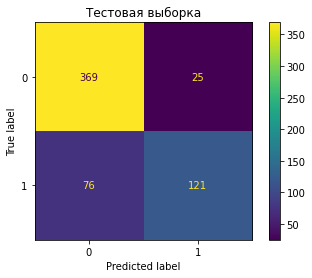

In [32]:
confusion_matrix_finall = confusion_matrix(target_t, model.predict(features_t))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_finall, display_labels = [0, 1])
cm_display.plot()
plt.title('Тестовая выборка')
plt.show()

Найдем значения других метрик, связанных с `Confusion matrix` - `recall`, `precision`:

In [33]:
r_t_rf = tp_t / (tp_t + fn_t)
p_t_rf = tp_t / (tp_t + fp_t)
print(f'Recall_test = {r_t_rf}')
print(f'Precision_test = {p_t_rf}')

Recall_test = 0.6142131979695431
Precision_test = 0.8287671232876712


Доля правильных наденных объектов и предсказаний также хорошо возрасла по сравнению с валидационной выборкой! Теперь модель **предсказывает правильные объекты из правильно найденных в 82% случаях**. 

#### Roc-curve, Auc

Помимо вышеупомянутых метрик, посчитаем `Auc` и построим кривую `Roc`:

RandomForestClassifier: ROC AUC=0.848


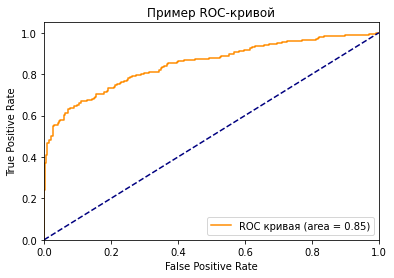

In [43]:
model = RandomForestClassifier(random_state=42, 
                               max_depth = grid.best_params_['max_depth'],
                               min_samples_leaf = grid.best_params_['min_samples_leaf'],
                               n_estimators = grid.best_params_['n_estimators'])
model.fit(features_tr, target_tr)
# получаем предказания
lr_probs = model.predict_proba(features_t)
# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(target_t, lr_probs)
print('RandomForestClassifier: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_t, lr_probs)
roc_auc_rf = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

Чем больше площадь под кривой (AUC), тем лучше классификация. В нашем случае `Auc` = 0.848. Оно близко к 1, что говорит о хорошем качестве модели. Другими словами, модель делает в целом правильные предсказания с вероятностью 0,84. 

### Сравнение с константной моделью

#### Accuracy

In [52]:
dc = DummyClassifier(strategy='most_frequent', random_state=412)
dc.fit(features_tr, target_tr)
a_tr = dc.score(features_valid, target_valid)
a_t = dc.score(features_t, target_t)
print("Accuracy на обучающей выборке:", a_tr)
print("Accuracy на тестовой выборке:", a_t)

Accuracy на обучающей выборке: 0.6652542372881356
Accuracy на тестовой выборке: 0.6666666666666666


#### Confusion matrix, recall, precision

Не будем останавливаться на одном показателе accurancy, проанализируем работу модели через другую метрику - `Confusion matrix`.

In [ ]:
tn_t, fp_t, fn_t, tp_t = confusion_matrix(target_test, dc.predict(features_test), labels = [0, 1]).ravel()

In [40]:
r_t = tp_t / (tp_t + fn_t)
p_t = tp_t / (tp_t + fp_t)
print(f'Recall_test = {r_t}')
print(f'Precision_test = {p_t}')

Recall_test = 0.0
Precision_test = nan


/tmp/ipykernel_876/657516081.py:2: RuntimeWarning: invalid value encountered in long_scalars
  p_t = tp_t / (tp_t + fp_t)


Из-за особенности модели сложно опираться на метрики `recall`, `precision`, поэтому дополнительно оценим `Auc`.

#### Roc-curve, Auc

Помимо вышеупомянутых метрик, посчитаем `Auc` и построим кривую `Roc`:

DummyClassifier: ROC AUC=0.500


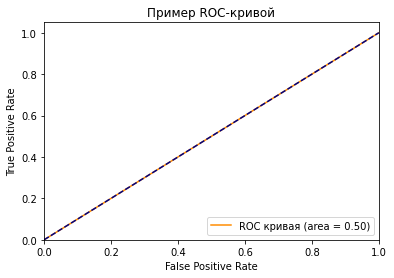

In [44]:
model = dc
model.fit(features_tr, target_tr)
# получаем предказания
lr_probs = model.predict_proba(features_t)
# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(target_t, lr_probs)
print('DummyClassifier: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_t, lr_probs)
roc_auc_dc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc_dc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

Auc = 0.5 это очень плохой показатель для модели, который говорит, что предсказания выбираются правильно лишь в 50%!

#### Финальная таблица

In [46]:
all_in_one = {
    'model_type' : ['Random Forest', 'Dummy'],
    'accuracy_test' : [round(result, 3), round(a_t, 3)],
    'is_accuracy_valid_less' : [best_result_rf < result ,a_t > a_tr],
    'recall_test' : [round(r_t_rf, 3), round(r_t ,3)],
    'precision_test' : [round(p_t_rf, 3), round(p_t ,3)],
    'roc_auc' : [round(roc_auc_rf, 3), round(roc_auc_dc, 3)]
}
all_in_one = pd.DataFrame(all_in_one)
all_in_one

,model_type,accuracy_test,is_accuracy_valid_less,recall_test,precision_test,roc_auc
0,Random Forest,0.829,True,0.614,0.829,0.848
1,Dummy,0.667,False,0.000,NaN,0.500


Модель прошла проверку!

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Все верно. 

👍 что используешь специальную обертку для проверки константных моделей

</div>

## Вывод

Исходя из всех использованных метрик качества, пришли к тому, что RandomForest больше всего подойдет для определения подходящего тарифа, ибо доля правильных ответов у него наибольшее. Однако, он самый медлительный. Остальные модели не подошли не только из-за accurancy, но и точности, полности работы алгоритма. 


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>


Диана, ты старательно выполнила работу, все четко, осмысленно. Вижу у тебя получается в ML,  дальше будет интересней )  


Но можно сделать поинтересней.  Я оставил небольшие советы и вопросики (если есть время и желание можешь воспользоваться/ответить): 

- обрати внимание на проверку сбалансированность классов в таргете
- использовать stratify
- добавить график метрики    
- посоветовал посмотреть в сторону GreedSearch
- как можно улучшить результаты 

Замечания на будущее:
    
- Комментарии к коду отсутствуют - коллеги могут не понять хода твоих мыслей. 
- Было бы замечательно, в выводе немножко о данных, работе с ними (пусть даже никакой работы и не было), моделировании и полученных результатах. Это важно потому что когда проект захочет посмотреть будущий работодатель (или начальник), у него может не быть времени на подробный разбор кода. Вероятнее всего он бегло просмотрит код, а из общего вывода захочет получить представление о всей работе.

 
    
Обязательное к исправлению:


- к моменту проверки качества прогноза на тесте, приходим с уже одной выбранной моделью с лучшими гиперпараметрами выбранными на валидации



Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 


</div>






## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
